In [71]:
#install.packages("reshape2")
#install.packages("car")
library(ggplot2)
library(dplyr)
library(reshape2)
library(car)

###Introduction
To start out initially, I had the idea of predicting the price of the Bored Ape Yacht Club NFT, based on individual traits. These traits ranged from background color (red, yellow, green, gold, etc.) to mouth shape (open, smiling, closed). However there was a little bit of a problem when dealing with this, as there would be so many categorical predictors for trying to estimate the price when using a single category of traits. For example, if I wanted to predict the price of a bored ape for using the mouth shape, There are 33 different permutations. That would result in me having 33 different predictors if I wanted to estimate the price only using the mouth shape using one-hot encoding. (Adjusted $\textrm{R}^2$ would not be happy). An ANOVA model would be a much better model as there a lots of different group means we could compare.

So instead of that, I decided that taking a look at a dataset from this [Yahoo Finance](https://finance.yahoo.com/quote/ETH-USD/history?period1=1689033600&period2=1696982400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true) pricing would be better. This dataset is the ETH-USD pricing from 04/06/23 - 10/06/23


In [2]:
ETH = read.csv("ETH-USD_6M.csv")
head(ETH)

,Date,Open,High,Low,Close,Adj.Close,Volume
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2023-04-06,1909.144,1909.272,1857.085,1872.923,1872.923,8263191830
2,2023-04-07,1872.734,1882.299,1845.994,1865.636,1865.636,8356130492
3,2023-04-08,1864.679,1879.108,1848.875,1849.498,1849.498,5016362733
4,2023-04-09,1849.672,1873.057,1828.700,1859.388,1859.388,6361497715
5,2023-04-10,1859.741,1917.300,1848.164,1911.208,1911.208,8380134275
6,2023-04-11,1911.376,1936.728,1886.534,1892.190,1892.190,8877222956


###Regression Objectives
The Goal of this regression analysis is to estimate the volume of transaction given in a certain date. Looking at the parameters, we have:
- Date
- Open (average trading price at the start of the day)
- Close
- High (highest traded value for that day)
- Low (lowest traded value for that day)
- adj.close (same as Low for Cryptocurrencies since you can trade 24/7)
- Volume (Amount of ETH traded that day in USD)

Just based on some preliminary scouting of the data, there are a few variables I'd like to add that I think would be a big indicator of when volume is highly traded. Firstly, I think that people will trade more on days when the open and close delta is high and similarly when the high and low delta is high. Additionally, I think it would be interesting to see if there is any importance to the day of the week to see if people generally trade more on certain days.

In [ ]:
#Remove the 'Adj Close' Column
ETH = ETH[, !names(ETH) %in% c('Adj.Close')]

#new variable for the abosolute differece between open and close
ETH$Abs_Open_Close_Diff = abs(ETH$Open - ETH$Close)

#same for high low
ETH$Abs_High_Low_Diff = abs(ETH$High - ETH$Low)

In [54]:
ETH$Date = as.Date(ETH$Date, format = "%Y-%m-%d")
days_of_week = character(nrow(ETH))

for(i in 1:nrow(ETH)){
  days_of_week[i] = weekdays(ETH$Date[i])
}
ETH$Day_of_Week = days_of_week

In [55]:
head(ETH)

,Date,Open,High,Low,Close,Volume,Abs_Open_Close_Diff,Abs_High_Low_Diff,Weekend,Day_of_Week
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,2023-04-06,1909.144,1909.272,1857.085,1872.923,8263191830,36.220948,52.18665,No,Thursday
2,2023-04-07,1872.734,1882.299,1845.994,1865.636,8356130492,7.098023,36.30530,No,Friday
3,2023-04-08,1864.679,1879.108,1848.875,1849.498,5016362733,15.180908,30.23230,No,Saturday
4,2023-04-09,1849.672,1873.057,1828.700,1859.388,6361497715,9.715576,44.35730,No,Sunday
5,2023-04-10,1859.741,1917.300,1848.164,1911.208,8380134275,51.466309,69.13599,No,Monday
6,2023-04-11,1911.376,1936.728,1886.534,1892.190,8877222956,19.186157,50.19409,No,Tuesday


,Open,High,Low,Close,Volume,Abs_Open_Close_Diff,Abs_High_Low_Diff
Open,1.0000000,0.9783859,0.96423061,0.9497405,0.4123757,0.20611870,0.24745131
High,0.9783859,1.0000000,0.96105624,0.9794491,0.5040691,0.29216831,0.33632550
Low,0.9642306,0.9610562,1.00000000,0.9779133,0.2856826,0.06215029,0.06297358
Close,0.9497405,0.9794491,0.97791333,1.0000000,0.4111605,0.18782433,0.20466328
Volume,0.4123757,0.5040691,0.28568263,0.4111605,1.0000000,0.67923771,0.84684570
Abs_Open_Close_Diff,0.2061187,0.2921683,0.06215029,0.1878243,0.6792377,1.00000000,0.84333715
Abs_High_Low_Diff,0.2474513,0.3363255,0.06297358,0.2046633,0.8468457,0.84333715,1.00000000


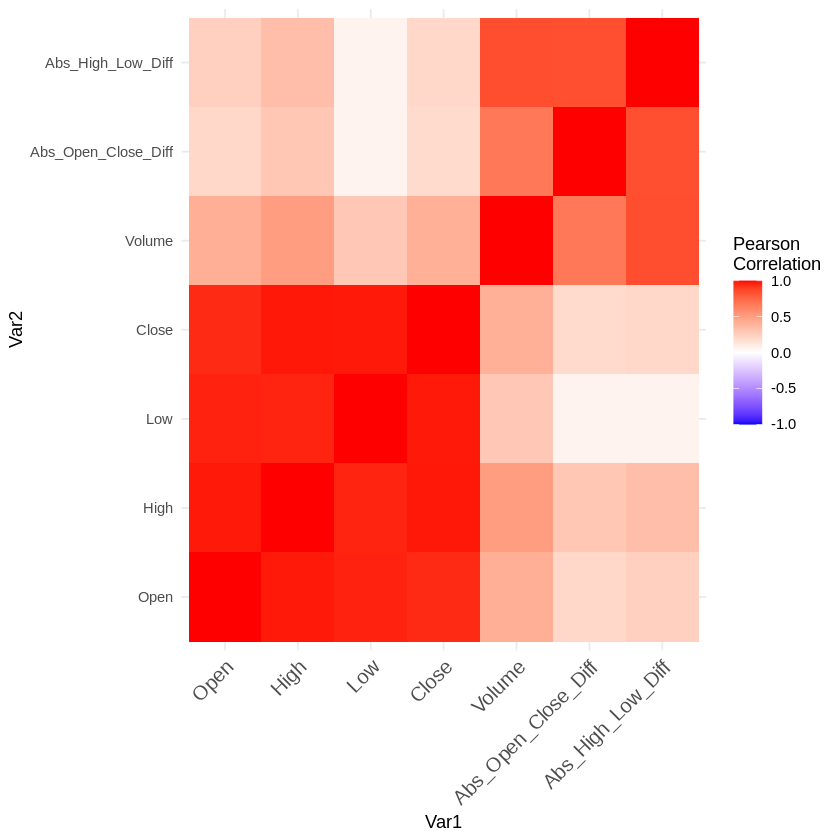

In [31]:
cor(ETH[, !names(ETH) %in% c('Date', 'Day_of_Week')])
melted_cormat <- melt(cor(ETH[, !names(ETH) %in% c('Date', 'Day_of_Week')]))  # Assuming the first column is Date
ggplot(data = melted_cormat, aes(x=Var1, y=Var2, fill=value)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white",
                       midpoint = 0, limit = c(-1,1), space = "Lab",
                       name="Pearson\nCorrelation") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, vjust = 1,
                                   size = 12, hjust = 1))

looking at our correlation matrix, we see that our initial intuiton may be correct! Abs_Open_Close_diff and Abs_High_Low_Diff are highly correlated with Volume with values of 0.679 and 0.847 respectively.

Additionally, Open and High have a correlation of approximately 0.978 which indicated a very strong positive correlation. This makes sense becaue the highest and opening of a trading period are often closely related. There are other variables that are also highly correlated, but this is typical for time series data.

      Date                 Open           High           Low      
 Min.   :2023-04-06   Min.   :1551   Min.   :1596   Min.   :1533  
 1st Qu.:2023-05-21   1st Qu.:1677   1st Qu.:1715   1st Qu.:1648  
 Median :2023-07-06   Median :1842   Median :1862   Median :1818  
 Mean   :2023-07-06   Mean   :1805   Mean   :1829   Mean   :1778  
 3rd Qu.:2023-08-21   3rd Qu.:1881   3rd Qu.:1910   3rd Qu.:1857  
 Max.   :2023-10-06   Max.   :2120   Max.   :2137   Max.   :2077  
     Close          Volume          Abs_Open_Close_Diff Abs_High_Low_Diff
 Min.   :1552   Min.   :2.082e+09   Min.   :  0.3007    Min.   :  6.562  
 1st Qu.:1671   1st Qu.:4.536e+09   1st Qu.:  7.3254    1st Qu.: 30.031  
 Median :1841   Median :5.814e+09   Median : 15.6043    Median : 41.205  
 Mean   :1803   Mean   :6.295e+09   Mean   : 25.7722    Mean   : 51.425  
 3rd Qu.:1879   3rd Qu.:7.648e+09   3rd Qu.: 33.5312    3rd Qu.: 63.956  
 Max.   :2120   Max.   :1.630e+10   Max.   :167.5428    Max.   :256.002  
 Day_of_Week 

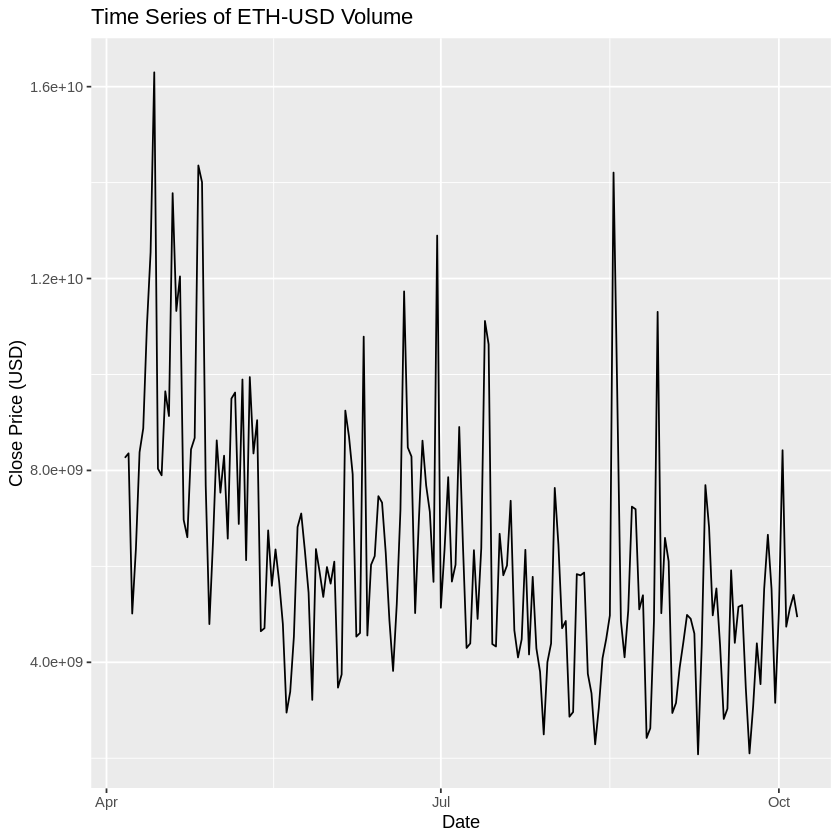

In [37]:
# Display summary statistics
summary(ETH)


ggplot(ETH, aes(x=Date, y=Volume)) +
  geom_line() +
  ggtitle('Time Series of ETH-USD Volume') +
  xlab('Date') +
  ylab('Close Price (USD)')


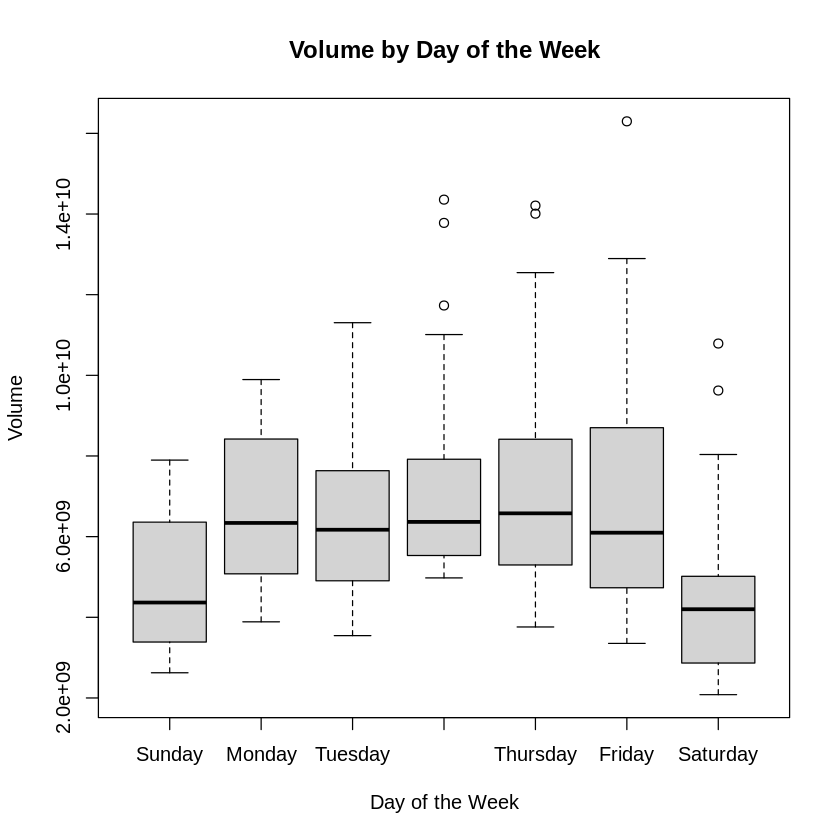

In [40]:
ETH$Day_of_Week <- factor(ETH$Day_of_Week, levels = c("Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"))

boxplot(Volume ~ Day_of_Week, data = ETH, main = "Volume by Day of the Week", xlab = "Day of the Week", ylab = "Volume")


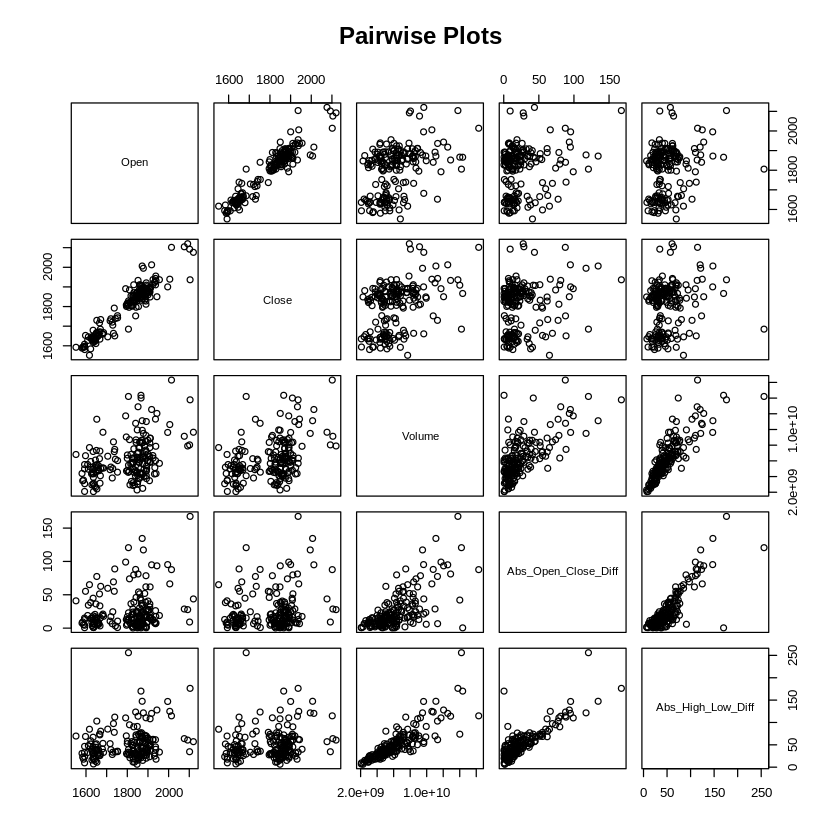

In [39]:
pairs(ETH[, c("Open", "Close", "Volume", "Abs_Open_Close_Diff", "Abs_High_Low_Diff")], main = "Pairwise Plots")


WE LOVE CRYPTO BECAUSE IT SO VOLITILE!! Even though there was really no big news in crypto over the last 6 Months the closing price will jump dramatically for seemingly no reason.

Also its interesting to note that people tend to trade less on the weekends as opposed to the weekdays. Lets change our "Day of Week" Variable to indicate whether it is the weekend or not.





In [56]:
# Convert 'Day_of_Week' to 'Weekend' or 'Weekday'
ETH$Day_of_Week <- ifelse(ETH$Day_of_Week %in% c("Saturday", "Sunday"), "Yes", "No")

In [57]:
# Rename 'Day_of_Week' to 'Weekend'
colnames(ETH)[colnames(ETH)=="Day_of_Week"] = "Weekend"

###Regression Model
let's build our model. Based on our EDA, I think that these variables should be a good starting point:
- Open
- Close
- Abs_Open_Close_Diff
- Abs_High_Low_Diff
- Weekend

Since we wont be doing any predicting with this model and are more interestedin the relationships among the variables, we will not need to split the data into training and testing data.

In [65]:
model <- lm(Volume ~ Open + Close + Abs_Open_Close_Diff + Abs_High_Low_Diff + Weekend, data = ETH)
summary(model)


Call:
lm(formula = Volume ~ Open + Close + Abs_Open_Close_Diff + Abs_High_Low_Diff + 
    Weekend, data = ETH)

Residuals:
       Min         1Q     Median         3Q        Max 
-3.380e+09 -7.242e+08 -3.349e+07  4.555e+08  5.367e+09 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -6.359e+09  1.264e+09  -5.031 1.19e-06 ***
Open                -4.035e+06  2.238e+06  -1.803   0.0730 .  
Close                9.564e+06  2.205e+06   4.338 2.41e-05 ***
Abs_Open_Close_Diff -1.110e+07  5.477e+06  -2.027   0.0442 *  
Abs_High_Low_Diff    6.429e+07  4.667e+06  13.775  < 2e-16 ***
WeekendYes          -1.173e+09  1.920e+08  -6.108 6.17e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.114e+09 on 178 degrees of freedom
Multiple R-squared:  0.8238,	Adjusted R-squared:  0.8188 
F-statistic: 166.4 on 5 and 178 DF,  p-value: < 2.2e-16


Although initially it looks like almost all of these coefficeints are statsiticallly siginficant, a further look at the coefficents tell us a different story. why is Open's Coefficient $ -5\times 10^{6}$ while Close's coefficient $1\times 10^7$ - This is the issue of Multicollinearity. Because these variables are VERY correlated, the presence of one bolsters the other. We can use VIF to see which variables are the most problematic.

In [73]:
vif(model)

Open               Close Abs_Open_Close_Diff   Abs_High_Low_Diff 
          10.712029           10.457467            3.523985            3.813017 
            Weekend 
           1.108290

In [76]:
model2 = lm(formula = Volume ~ Open + Abs_Open_Close_Diff + Abs_High_Low_Diff + Weekend,
    data = ETH)
summary(model2)


Call:
lm(formula = Volume ~ Open + Abs_Open_Close_Diff + Abs_High_Low_Diff + 
    Weekend, data = ETH)

Residuals:
       Min         1Q     Median         3Q        Max 
-4.153e+09 -7.677e+08 -8.953e+07  4.811e+08  5.817e+09 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -5.621e+09  1.313e+09  -4.280 3.04e-05 ***
Open                 5.170e+06  7.442e+05   6.948 6.65e-11 ***
Abs_Open_Close_Diff -8.499e+06  5.709e+06  -1.489    0.138    
Abs_High_Low_Diff    6.122e+07  4.837e+06  12.655  < 2e-16 ***
WeekendYes          -1.220e+09  2.010e+08  -6.068 7.55e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.168e+09 on 179 degrees of freedom
Multiple R-squared:  0.8051,	Adjusted R-squared:  0.8008 
F-statistic: 184.9 on 4 and 179 DF,  p-value: < 2.2e-16


In [77]:
vif(model2)

Open Abs_Open_Close_Diff   Abs_High_Low_Diff             Weekend 
           1.077582            3.481662            3.725146            1.104784

When we take a look at this model, we see that the p-values for all the predictors are significant, except for ABS_open_Close_Diff. It seems that the two Absolute Value measures are also correlated, and most of the variance is already explained by the other. Lets remove It and see what happens.

In [82]:
model3 = lm(Volume ~ Open + Abs_High_Low_Diff + Weekend, data = ETH)
summary(model3)


Call:
lm(formula = Volume ~ Open + Abs_High_Low_Diff + Weekend, data = ETH)

Residuals:
       Min         1Q     Median         3Q        Max 
-3.745e+09 -7.890e+08 -6.647e+07  4.805e+08  5.805e+09 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -5.552e+09  1.317e+09  -4.216 3.93e-05 ***
Open               5.185e+06  7.467e+05   6.944 6.70e-11 ***
Abs_High_Low_Diff  5.525e+07  2.719e+06  20.317  < 2e-16 ***
WeekendYes        -1.242e+09  2.012e+08  -6.173 4.33e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.172e+09 on 180 degrees of freedom
Multiple R-squared:  0.8027,	Adjusted R-squared:  0.7994 
F-statistic: 244.1 on 3 and 180 DF,  p-value: < 2.2e-16


In [81]:
vif(model3)

Open Abs_High_Low_Diff           Weekend 
         1.077408          1.169514          1.098830

Finally, let's transform our response so that we have it in millions of dollars. This makes it easier for us to interpret the coefficients.

In [83]:
model.final = model3 = lm(Volume/1000000 ~ Open + Abs_High_Low_Diff + Weekend, data = ETH)
summary(model3)


Call:
lm(formula = Volume/1e+06 ~ Open + Abs_High_Low_Diff + Weekend, 
    data = ETH)

Residuals:
    Min      1Q  Median      3Q     Max 
-3745.1  -789.0   -66.5   480.5  5804.9 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -5552.2187  1316.8737  -4.216 3.93e-05 ***
Open                  5.1846     0.7467   6.944 6.70e-11 ***
Abs_High_Low_Diff    55.2521     2.7195  20.317  < 2e-16 ***
WeekendYes        -1241.8429   201.1818  -6.173 4.33e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1172 on 180 degrees of freedom
Multiple R-squared:  0.8027,	Adjusted R-squared:  0.7994 
F-statistic: 244.1 on 3 and 180 DF,  p-value: < 2.2e-16


In [84]:
confint(model3)

,2.5 %,97.5 %
(Intercept),-8150.714526,-2953.72292
Open,3.711268,6.65792
Abs_High_Low_Diff,49.886035,60.61825
WeekendYes,-1638.821056,-844.86478


**Objective:**

The primary objective of this regression analysis was to estimate the trading volume of Ethereum (ETH) on a given date, based on various market features. The analysis was conducted using a 6-month dataset of ETH-USD pricing, which included key parameters like Open, Close, High, Low, and trading volume in USD.

**Methodology:**

A multiple linear regression approach was employed to analyze Ethereum's daily trading volume. The initial set of predictor variables included opening and closing prices, the absolute difference between these prices, the absolute difference between the day's high and low prices, and a categorical variable for weekends. After confronting issues of multicollinearity and variable significance, the model was refined for optimal performance.

**Final Model Parameters:**

The finalized model incorporates the following significant variables:

- Opening Price (Open)

- Absolute Difference Between High and Low Price (Abs_High_Low_Diff)
- Weekend Indicator (WeekendYes)
The model demonstrates a strong fit, with an Adjusted
$\textrm{R}^2$ value of 0.7994, indicating that approximately 80% of the variance in the trading volume is explained by the model.

**Key Findings:**
1. A one-dollar increase in the opening price correlates with an increase in trading volume by approximately 5.18 million USD.
 *95% confidence interval: (3.71,	6.65) million USD*
2. A one-dollar increase in the absolute difference between the day's high and low prices corresponds to an increase in trading volume by approximately 55.25 million USD.*95% confidence interval: (49.89	60.62) million USD*
3. Weekends are associated with a decrease in trading volume by approximately 1.24 billion USD.*95% confidence interval: (-1.639,	-0.845) Billion USD*

**Implications:**

The model provides substantial insights into the factors influencing Ethereum's daily trading volume. Notably, it's not solely price-dependent; temporal factors, such as weekends, also have a significant impact.

**Future Recommendations:**

For further improvement, we could add more simple factors like public opinion on the market or major economic events to the model.

**Conclusion:**

This regression model serves as a robust tool for understanding the dynamics of Ethereum trading volume. It elucidates key variables that are significantly associated with volume changes, providing valuable insights for traders and policy makers alike. The next steps could involve extending this model to include more complex factors to further enhance its predictive power.